In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gensim

In [2]:
def read_only_consistent(path):
    # create a dataframe consisting of word and PoS tag
    sentences = []
    with open(path, 'r', encoding="utf-8") as f:
        data = f.readlines()
        r = len(data)
        i = 0
        while(i < r):
            sentence = []
            ne_representation = []
            while(i < r and data[i] != "\n"):
                parts = data[i].split(" ")
                word = parts[0].strip()
                ne = parts[-1].strip()

                ne_representation.append(ne)
                sentence.append(word) 
                i += 1
            i+=1
            sentences.append((sentence, ne_representation))
        return sentences

# read test, dev and train csv files
train = read_only_consistent("data/gungor.ner.train.14.only_consistent")
dev = read_only_consistent("data/gungor.ner.dev.14.only_consistent")
test = read_only_consistent("data/gungor.ner.test.14.only_consistent")

In [3]:
import random
sentence, pos_repr = random.choice(train)
print(sentence, ":", pos_repr)

['Ecevit', ',', "Şener'in", 'açıklamasına', 'dikkat', 'çekerek', '"', 'Anlaşılan', 'o', 'ki', "Kutan'ın", 'önerisi', 'başkent', 'kulislerinden', 'çok', 'kendi', 'partisini', 'karıştırmış', '"', 'diyor', 've', '"', 'Her', 'gün', 'yeni', 'bir', 'seçim', 'tarihi', 'ortaya', 'atarak', "Türkiye'yi", 'belirsizlik', 'ortamına', 'sokmaya', 'kimsenin', 'hakkı', 'yok', '.'] : ['I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [4]:

# create a dataframe
traindf = pd.DataFrame(
    {'sentence': [i[0] for i in train],
        'ne': [i[1] for i in train]
    })

testdf = pd.DataFrame(
    {'sentence': [i[0] for i in test],
        'ne': [i[1] for i in test]
    })

devdf = pd.DataFrame(
    {'sentence': [i[0] for i in dev],
        'ne': [i[1] for i in dev]
    })


traindf.head(1), devdf.head(1), testdf.head(1)

(                                            sentence   
 0  [Müzik, Müzik, Şenliği'ne, hazırlanın, POZİTİF...  \
 
                                                   ne  
 0  [O, O, O, O, I-ORG, I-ORG, I-ORG, I-ORG, O, O,...  ,
                    sentence             ne
 0  [Üretken, ülke, Türkiye]  [O, O, I-LOC],
                                             sentence   
 0  [Bunlar, ,, mücadelenin, kesin, galibini, beli...  \
 
                                   ne  
 0  [O, O, O, O, O, O, O, O, O, O, O]  )

In [5]:
trainx = traindf['sentence']
trainy = traindf['ne']

trainx[0], trainy[0]

(['Müzik',
  'Müzik',
  "Şenliği'ne",
  'hazırlanın',
  'POZİTİF',
  've',
  'Açık',
  'Radyo',
  'işbirliğiyle',
  'düzenlenecek',
  'olan',
  'İstanbul',
  'Müzik',
  'Şenliği',
  '2',
  ',',
  'müzikseverlere',
  'Aralık',
  'ayında',
  'merhaba',
  'demeye',
  'hazırlanıyor'],
 ['O',
  'O',
  'O',
  'O',
  'I-ORG',
  'I-ORG',
  'I-ORG',
  'I-ORG',
  'O',
  'O',
  'O',
  'I-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [6]:
####### VECTORIZATION #######
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(trainx)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(trainx)  # use the tokeniser to encode input sequence

In [7]:
####### VECTORIZATION #######
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(trainy)                    # fit tokeniser on data
Y_encoded = tag_tokenizer.texts_to_sequences(trainy)  # use the tokeniser to encode input sequence

In [8]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [9]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 152


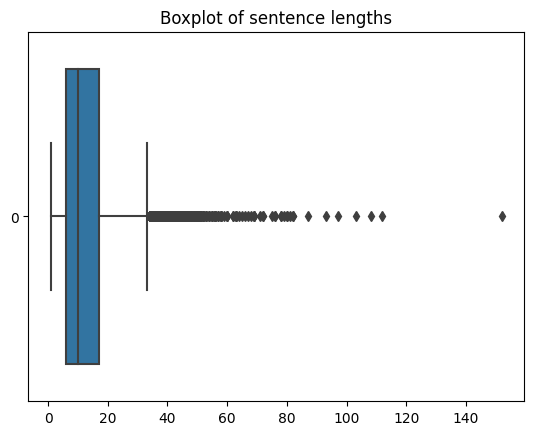

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(lengths, orient='h')
plt.title("Boxplot of sentence lengths")
plt.show()

In [11]:
MAX_SEQ_LENGTH = 130  # sequences greater than MAX_SEQ_LENGTH in length will be truncated

X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [12]:
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
  1558  1558 23896 11290 23897     5   198  2255 15304  2953    24   113
  1558 15305   139     1 23898  1898   396 11291  7263  1701] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [13]:
MODEL = "C:/Users/karab/Desktop/Models/glove.txt"
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

#load fasttext embeddings
print('loading word embeddings...')
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
    MODEL,
    binary=False,
    no_header=True)

loading word embeddings...


In [14]:
# create an empty embedding matrix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:  embedding_weights[index, :] = word_vectors[word]
    except KeyError: pass

In [15]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (53214, 300)


In [16]:
Y_final = tf.keras.utils.to_categorical(Y_padded)
# print Y of the first output sequence
print(Y_final.shape)  # (number of sequences, length of each sequence, number of entities)

(25514, 130, 5)


In [17]:
### Perform all the operations for dev set ###
devx = devdf['sentence']
devy = devdf['ne']

devx_encoded = word_tokenizer.texts_to_sequences(devx)
devy_encoded = tag_tokenizer.texts_to_sequences(devy)

devx_padded = tf.keras.preprocessing.sequence.pad_sequences(devx_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
devy_padded = tf.keras.preprocessing.sequence.pad_sequences(devy_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

devy_final= tf.keras.utils.to_categorical(devy_padded)

In [18]:
### Perform all the operations for test set ###
testx = testdf['sentence']
testy = testdf['ne']

testx_encoded = word_tokenizer.texts_to_sequences(testx)
testy_encoded = tag_tokenizer.texts_to_sequences(testy)

testx_padded = tf.keras.preprocessing.sequence.pad_sequences(testx_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
testy_padded = tf.keras.preprocessing.sequence.pad_sequences(testy_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

testy_final = tf.keras.utils.to_categorical(testy_padded)

In [19]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_padded.shape))
print('Shape of output sequences: {}'.format(Y_final.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(devx_padded.shape))
print('Shape of output sequences: {}'.format(devy_final.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(testx_padded.shape))
print('Shape of output sequences: {}'.format(testy_final.shape))

TRAINING DATA
Shape of input sequences: (25514, 130)
Shape of output sequences: (25514, 130, 5)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (2954, 130)
Shape of output sequences: (2954, 130, 5)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (2915, 130)
Shape of output sequences: (2915, 130, 5)


In [20]:
# print unique elements in trainy
print("Unique elements in trainy: {}".format(set([item for sublist in trainy for item in sublist])))
# print unique elements in devy
print("Unique elements in devy: {}".format(set([item for sublist in devy for item in sublist])))
# print unique elements in testy
print("Unique elements in testy: {}".format(set([item for sublist in testy for item in sublist])))

Unique elements in trainy: {'I-LOC', 'I-ORG', 'O', 'I-PER'}
Unique elements in devy: {'I-LOC', 'I-ORG', 'O', 'I-PER'}
Unique elements in testy: {'I-LOC', 'I-ORG', 'O', 'I-PER'}


In [21]:
# total number of tags
NUM_CLASSES = Y_final.shape[2]
NUM_CLASSES

5

In [22]:
# import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Embedding

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = False
))
bidirect_model.add(Bidirectional(LSTM(16, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [23]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [24]:
bidirect_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 300)          15964200  
                                                                 
 bidirectional (Bidirectiona  (None, 130, 32)          40576     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 130, 5)           165       
 ibuted)                                                         
                                                                 
Total params: 16,004,941
Trainable params: 40,741
Non-trainable params: 15,964,200
_________________________________________________________________


In [25]:
bidirect_training = bidirect_model.fit(X_padded, Y_final, batch_size=128, epochs=10, validation_data=(devx_padded, devy_final))

Epoch 1/10
200/200 [==============================] - 17s 41ms/step - loss: 0.3113 - acc: 0.9788 - val_loss: 0.0802 - val_acc: 0.9785
Epoch 2/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0323 - acc: 0.9912 - val_loss: 0.0813 - val_acc: 0.9789
Epoch 3/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0254 - acc: 0.9933 - val_loss: 0.0838 - val_acc: 0.9787
Epoch 4/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0218 - acc: 0.9942 - val_loss: 0.0871 - val_acc: 0.9786
Epoch 5/10
200/200 [==============================] - 7s 35ms/step - loss: 0.0193 - acc: 0.9948 - val_loss: 0.0906 - val_acc: 0.9785
Epoch 6/10
200/200 [==============================] - 7s 35ms/step - loss: 0.0176 - acc: 0.9952 - val_loss: 0.0918 - val_acc: 0.9785
Epoch 7/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0162 - acc: 0.9955 - val_loss: 0.0935 - val_acc: 0.9786
Epoch 8/10
200/200 [==============================] - 7s 33ms/step -

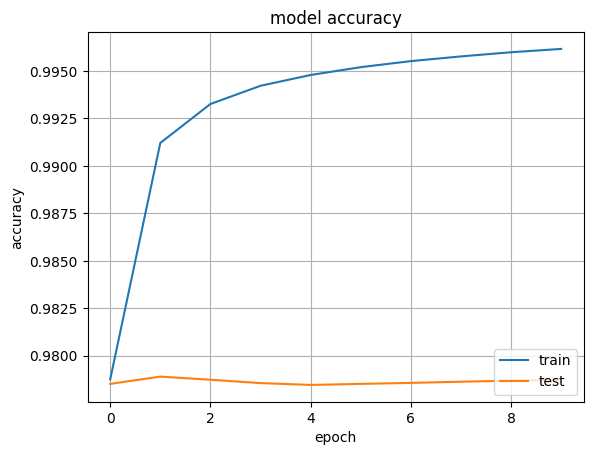

In [26]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [27]:
loss, accuracy = bidirect_model.evaluate(testx_padded, testy_final, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

92/92 [==============================] - 2s 24ms/step - loss: 0.0998 - acc: 0.9784
Loss: 0.09979955852031708,
Accuracy: 0.9783982038497925
